In [2]:
!pip install medpy
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=a5312c79754ede4fc2b00a6235bc5ecca9164ae208f64faed20dc5e85aa5a60e
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [18]:
import sys
sys.path.append('/kaggle/input/required2/other/default/1')
import matplotlib
matplotlib.use('Agg') 
from scipy.stats import entropy
from numpy.linalg import norm
from matplotlib.ticker import FuncFormatter
from monai.metrics import compute_hausdorff_distance
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pylab
import os
import matplotlib.pyplot as plt

class AEDetector2D:
    def __init__(self, model_class, model_path, p=2, device='cuda', model_kwargs=None):
        self.device = torch.device(device)
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.p = p

    def mark(self, X):
        """X: 4D tensor [N, 4, 240, 240]"""
        with torch.no_grad():
            X = X.to(self.device)
            recon = self.model(X)
            error = torch.abs(X - recon)
            if self.p != 1:
                error = torch.pow(error, self.p)
            return torch.mean(error.view(X.size(0), -1), dim=1).cpu().numpy()


class SimpleReformer2D:
    def __init__(self, model_class, model_path, device='cuda', model_kwargs=None):
        self.device = torch.device(device)
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

    def heal(self, X):
        """Medical-preserving reconstruction"""
        with torch.no_grad():
            X = X.to(self.device)
            recon = self.model(X)
            
            # Residual approach: only apply small corrections
            residual = recon - X
            
            # Conservative blending (only 10-20% reconstruction)
            alpha = 0.3  # Much smaller than before
            healed = X + alpha * residual
            
            return torch.clamp(healed, 0, 1)

class ClassifierUNet:
    def __init__(self, model_class, classifier_path, device='cuda', model_kwargs=None):
        """
        UNet-based classifier wrapper for medical image segmentation/classification.
        
        model_class: UNet architecture class
        classifier_path: Path to saved model weights (.pth)
        device: torch.device or string ("cuda"/"cpu")
        model_kwargs: Dictionary of kwargs for UNet initialization
        """
        self.path = classifier_path
        self.device = torch.device(device)
        
        # Initialize UNet with medical imaging defaults
        default_kwargs = {
            'in_channels': 4,        # For BraTS multi-modal input
            'out_channels': 4,       # Tumor sub-regions
            'features': [64, 128, 256]
        }
        combined_kwargs = {**default_kwargs, **(model_kwargs or {})}
        
        self.model = model_class(**combined_kwargs).to(self.device)
        self.model.load_state_dict(torch.load(classifier_path, map_location=self.device))
        self.model.eval()

    def classify(self, X, option="logit", T=1):
        """Returns flattened segmentation maps"""
        with torch.no_grad():
            # Move input to model's device
            X = X.to(self.device)
            
            if X.ndim == 5:  # 3D volumes [N, C, D, H, W]
                N, C, D, H, W = X.shape
                X = X.permute(0, 2, 1, 3, 4).reshape(N*D, C, H, W)
                
            outputs = self.model(X)  # Now both on same device
            
            if option == "logit":
                return outputs.view(-1).cpu().numpy()
            elif option == "prob":
                probs = F.softmax(outputs / T, dim=1)
                return probs.view(-1).cpu().numpy()

    def _aggregate_predictions(self, seg_map):
        """Convert segmentation map to class probabilities"""
        # Global average pooling over spatial dimensions
        return seg_map.mean(dim=[2, 3])  # [N, num_classes]

    def print(self):
        return f"ClassifierUNet:{os.path.basename(self.path)}"

class OperatorBraTS:
    def __init__(self, data_wrapper, classifier, det_dict, reformer):
        """
        Operator for BraTS medical imaging pipeline handling 3D volumes and 2D slices.
        
        data: Object with .train_loader, .validation_loader, .test_loader
              Expects BraTS data format [N, 4, 155, 240, 240] (3D) or [N, 4, 240, 240] (2D)
        classifier: ClassifierUNet object with .classify() method
        det_dict: Dictionary of BraTS detectors (AEDetector3D/AEDetector2D)
        reformer: SimpleReformer3D/SimpleReformer2D object
        """
        self.data_wrapper = data_wrapper
        self.classifier = classifier
        self.det_dict = det_dict
        self.reformer = reformer

        # Load test data - handles both 3D volumes and 2D slices
        test_images, test_masks = next(iter(data_wrapper.test_loader))
        test_images = test_images.to(classifier.device)
        test_masks = test_masks.to(classifier.device)
        
        self.normal = self.operate(AttackDataBraTS(test_images, test_masks, "Normal"))
        
    def get_thrs(self, drop_rate):
        """Proper threshold calculation with medical validation data"""
        thrs = {}
        
        # Get sufficient validation samples (200+)
        val_loader = self.data_wrapper.val_loader
        val_samples = []
        for batch in val_loader:
            val_samples.append(batch[0])
            if len(val_samples) >= 200:
                break
        val_imgs = torch.cat(val_samples).to(self.classifier.device)

        print(f"Medical Validation: Using {len(val_imgs)} samples for thresholding")
        
        for name, detector in self.det_dict.items():
            marks = detector.mark(val_imgs)
            sorted_marks = np.sort(marks)
            num = int(len(marks) * drop_rate[name])
            thrs[name] = sorted_marks[-num] if num > 0 else np.inf
            
        return thrs

    def operate(self, untrusted_obj):
        device = next(self.classifier.model.parameters()).device
        X = untrusted_obj.data.to(device)
        Y_true = untrusted_obj.labels.to(device)

        with torch.no_grad():
            # Heal input
            X_prime = self.reformer.heal(X)
            
            # Get PROPER segmentation outputs (not flattened)
            Y_pred_logits = self.classifier.model(X)  # [N, C, H, W]
            Yp_pred_logits = self.classifier.model(X_prime)  # [N, C, H, W]
            
            # Convert to class predictions
            Y_pred = torch.argmax(Y_pred_logits, dim=1)  # [N, H, W]
            Yp_pred = torch.argmax(Yp_pred_logits, dim=1)  # [N, H, W]

        # Return actual segmentation maps for Dice calculation
        return list(zip(Y_pred.cpu().numpy(), Yp_pred.cpu().numpy(), Y_true.cpu().numpy()))

    def filter(self, X, thrs):
        all_pass = np.arange(X.shape[0])
        collector = {}
        D = None  # Initialize D
    
        # Handle 3D volumes for 2D detectors
        original_shape = X.shape
        if X.ndim == 5 and '2D' in next(iter(self.det_dict.values())).print():
            N, C, D, H, W = X.shape
            X = X.permute(0, 2, 1, 3, 4).reshape(N*D, C, H, W)
    
        for name, detector in self.det_dict.items():
            marks = detector.mark(X)
            idx_pass = np.argwhere(marks < thrs[name]).flatten()
            
            # Only remap if D was set (3D case)
            if D is not None:
                idx_pass = np.unique(idx_pass // D)
                
            collector[name] = len(idx_pass)
            all_pass = np.intersect1d(all_pass, idx_pass)
    
        return all_pass, collector

    def print(self):
        components = [self.reformer, self.classifier]
        return " ".join(obj.print() for obj in components)


class EvaluatorBraTS:
    def __init__(self, operator, untrusted_data, graph_dir="/kaggle/working/graphs"):
        """
        Evaluator for BraTS medical imaging defense strategies.

        operator: OperatorBraTS object
        untrusted_data: Adversarial/noisy BraTS data (3D volumes or 2D slices)
        graph_dir: Output directory for evaluation metrics
        """
        self.operator = operator
        self.untrusted_data = self.prepare_brats_data(untrusted_data)
        self.graph_dir = graph_dir
        os.makedirs(self.graph_dir, exist_ok=True)
        self.data_package = operator.operate(self.untrusted_data)
       

    def load_data(self, new_data):
        """Update evaluation data and reprocess through defense pipeline"""
        self.untrusted_data = self.prepare_brats_data(new_data)
        self.data_package = self.operator.operate(self.untrusted_data)

    def prepare_brats_data(self, data):
        device = next(self.operator.classifier.model.parameters()).device
        normalized_data = data.data.to(device)
        normalized_data = torch.clamp(normalized_data, 0.0, 1.0)
        
        # Changed from AttackData to AttackDataBraTS
        return AttackDataBraTS(normalized_data, data.labels.to(device), data.name)

    def get_normal_acc(self, normal_all_pass):
        """Volumetric accuracy calculation for BraTS"""
        normal_tups = self.operator.normal
        num_normal = len(normal_tups)
        
        # For 3D data: require correct predictions for all slices
        if self.operator.normal[0][0].ndim == 3:  # 3D volume
            both_acc = sum(np.all(filt_tup, axis=1).mean() for filt_tup in normal_tups[normal_all_pass])
        else:  # 2D slices
            both_acc = sum(1 for _, XpC in normal_tups[normal_all_pass] if XpC) / num_normal

        return both_acc, 0, 0, 0  # Simplified for medical imaging context

    def calculate_iou(self, pred_mask, target_mask):
        """
        Calculate Intersection over Union (IoU) for medical segmentation
        
        Args:
            pred_mask: Predicted segmentation mask
            target_mask: Ground truth segmentation mask
            
        Returns:
            IoU score for each class and mean IoU
        """
        iou_scores = []
        
        # Calculate IoU for each tumor class (excluding background)
        for class_id in [1, 2]:  # Tumor core and enhancing tumor
            pred_class = (pred_mask == class_id).astype(np.float32)
            target_class = (target_mask == class_id).astype(np.float32)
            
            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum() - intersection
            
            if union > 0:
                iou = intersection / (union + 1e-8)
                iou_scores.append(iou)
            else:
                # Handle empty tumor regions
                iou_scores.append(1.0 if (pred_class.sum() + target_class.sum()) == 0 else 0.0)
        
        return np.mean(iou_scores)

    def get_attack_acc(self, attack_pass):
        attack_tups = self.data_package
        
        if len(attack_tups) == 0:
            return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        
        def medical_dice_score(pred_mask, target_mask):
            """BraTS-optimized Dice calculation"""
            dice_scores = []
            
            # Match model's 3 output channels (background, tumor_core, enhancing_tumor)
            for class_id in [1, 2]:  # Skip background (0)
                pred_class = (pred_mask == class_id).astype(np.float32)
                target_class = (target_mask == class_id).astype(np.float32)
                
                intersection = (pred_class * target_class).sum()
                union = pred_class.sum() + target_class.sum()
                
                if union > 0:
                    dice = (2.0 * intersection) / (union + 1e-8)
                    dice_scores.append(dice)
                else:
                    # Handle empty tumor regions in prediction/target
                    dice_scores.append(1.0 if (pred_class.sum() + target_class.sum()) == 0 else 0.0)
            
            return np.mean(dice_scores)
        
        original_dice = []
        healed_dice = []
        original_iou = []
        healed_iou = []
        original_hd95 = []
        healed_hd95 = []
        
        for orig_pred, healed_pred, target in attack_tups:
            # Convert to binary tumor masks
            orig_pred_bin = (orig_pred > 0).astype(np.float32)
            healed_pred_bin = (healed_pred > 0).astype(np.float32)
            target_bin = (target > 0).astype(np.float32)
            
            def safe_hd95(pred, target):
                """Medical-safe HD95 calculation"""
                # Case 1: No tumor in ground truth
                if np.sum(target) == 0:
                    return 0.0  # Perfect score if no tumor exists
                
                # Case 2: Model failed to detect tumor
                if np.sum(pred) == 0:
                    return 300.0  # Penalty value (300mm = 30cm brain size)
                
                # Case 3: Valid tumor regions
                device = next(self.operator.classifier.model.parameters()).device
                pred_tensor = torch.from_numpy(pred).float().unsqueeze(0).unsqueeze(0).to(device)
                target_tensor = torch.from_numpy(target).float().unsqueeze(0).unsqueeze(0).to(device)
                return compute_hausdorff_distance(
                    pred_tensor, target_tensor, 
                    percentile=95,
                    include_background=False
                ).item()
            
            hd95_orig = safe_hd95(orig_pred_bin, target_bin)
            hd95_healed = safe_hd95(healed_pred_bin, target_bin)
                
            # Compute Dice
            orig_dice = medical_dice_score(orig_pred, target)
            healed_dice_score = medical_dice_score(healed_pred, target)
            
            # Compute IoU
            orig_iou = self.calculate_iou(orig_pred, target)
            healed_iou_score = self.calculate_iou(healed_pred, target)
            
            original_dice.append(orig_dice)
            healed_dice.append(healed_dice_score)
            original_iou.append(orig_iou)
            healed_iou.append(healed_iou_score)
            original_hd95.append(hd95_orig)
            healed_hd95.append(hd95_healed)
        
        return (
            np.mean(original_dice), 
            np.mean(healed_dice),
            np.mean(original_iou),
            np.mean(healed_iou),
            np.mean(original_hd95),
            np.mean(healed_hd95)
        )
        
    def plot_epsilon_sweep(self, graph_name, drop_rate, epsilons, 
                          attack_type="fgsm", data_dir='/kaggle/working/brats_attack_data/'):
        
        metrics = {
            'original_dice': [],
            'healed_dice': [],
            'original_iou': [],
            'healed_iou': [],
            'original_hd95': [],
            'healed_hd95': [],
            'detection_rate': []
        }
        
        device = next(self.operator.classifier.model.parameters()).device
        
        # Calculate thresholds once
        thresholds = self.operator.get_thrs(drop_rate)
        print(f"Using thresholds: {thresholds}")
        
        for eps in epsilons:
            print(f"\n=== DEBUGGING ε={eps} ===")
            
            # Load attack data
            attack_name = f"{attack_type}_{eps}"
            attack_data = load_obj(f"{attack_name}_attack", data_dir).to(device)
            attack_labels = load_obj(f"{attack_name}_labels", data_dir).to(device)
            
            print(f"Loaded {len(attack_data)} samples")
            
            # Process through defense pipeline
            attack_dataset = AttackDataBraTS(attack_data, attack_labels, name=attack_name)
            self.load_data(attack_dataset)
            
            # Test detector marks
            detector_marks = {}
            for name, detector in self.operator.det_dict.items():
                marks = detector.mark(attack_data[:5])  # Test first 5 samples
                detector_marks[name] = marks
                print(f"Detector {name} sample marks: {marks}")
            
            # Get filtering results
            attack_pass, stats = self.operator.filter(attack_dataset.data, thresholds)
            print(f"Filter stats: {stats}")
            print(f"Samples passed: {len(attack_pass)}/{len(attack_data)}")
            
            # Calculate metrics (now includes IoU)
            orig_dice, healed_dice, orig_iou, healed_iou, orig_hd95, healed_hd95 = self.get_attack_acc(attack_pass)
            detection_rate = 1.0 - (len(attack_pass) / len(attack_data))
            
            print(f"Original Dice: {orig_dice:.4f}")
            print(f"Healed Dice: {healed_dice:.4f}") 
            print(f"Original IoU: {orig_iou:.4f}")
            print(f"Healed IoU: {healed_iou:.4f}")
            print(f"Original HD95: {orig_hd95:.2f} mm")
            print(f"Healed HD95: {healed_hd95:.2f} mm")
            print(f"Detection Rate: {detection_rate:.4f}")
            
            # Store results
            metrics['original_dice'].append(orig_dice)
            metrics['healed_dice'].append(healed_dice)
            metrics['original_iou'].append(orig_iou)
            metrics['healed_iou'].append(healed_iou)
            metrics['original_hd95'].append(orig_hd95)
            metrics['healed_hd95'].append(healed_hd95)
            metrics['detection_rate'].append(detection_rate)

        valid_hd = [x for x in metrics['original_hd95'] + metrics['healed_hd95'] if np.isfinite(x)]
        max_hd = max(valid_hd) if valid_hd else 50.0  # 50mm clinical safety threshold
        
        # Plot 1: Dice and Detection Rate
        plt.figure(figsize=(12, 8))
        plt.plot(epsilons, metrics['original_dice'], 'r--', marker='o', linewidth=2, label="Original Dice")
        plt.plot(epsilons, metrics['healed_dice'], 'g-', marker='s', linewidth=2, label="Healed Dice")
        plt.plot(epsilons, metrics['detection_rate'], 'b:', marker='^', linewidth=2, label="Detection Rate")
                
        plt.xlabel("Attack Strength (ε)", fontsize=12)
        plt.ylabel("Dice Coefficient", fontsize=12)
        plt.title("BraTS Defense Performance vs Adversarial Strength", fontsize=14)
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.ylim(-0.05, 1.05)
                
        plt.savefig(f"{self.graph_dir}/{graph_name}_brats_dice.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Plot 2: IoU Metrics
        plt.figure(figsize=(12, 8))
        plt.plot(epsilons, metrics['original_iou'], 'orange', linestyle='--', marker='d', linewidth=2, label="Original IoU")
        plt.plot(epsilons, metrics['healed_iou'], 'purple', linestyle='-', marker='*', linewidth=2, label="Healed IoU")
        plt.plot(epsilons, metrics['detection_rate'], 'b:', marker='^', linewidth=2, label="Detection Rate")
        
        plt.xlabel("Attack Strength (ε)", fontsize=12)
        plt.ylabel("IoU Score", fontsize=12)
        plt.title("IoU Performance vs Adversarial Strength", fontsize=14)
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.ylim(-0.05, 1.05)
        
        plt.savefig(f"{self.graph_dir}/{graph_name}_brats_iou.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Plot 3: Hausdorff Distance
        plt.figure(figsize=(12, 8))
        plt.plot(epsilons, metrics['original_hd95'], 'm--', marker='x', linewidth=2, label="Original HD95")
        plt.plot(epsilons, metrics['healed_hd95'], 'c-', marker='+', linewidth=2, label="Healed HD95")
        
        plt.xlabel("Attack Strength (ε)", fontsize=12)
        plt.ylabel("Hausdorff Distance (mm)", fontsize=12)
        plt.title("Tumor Boundary Accuracy vs Adversarial Strength", fontsize=14)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, max_hd * 1.1)
        plt.yticks(np.arange(0, max_hd*1.1, 20))
        
        plt.savefig(f"{self.graph_dir}/{graph_name}_hausdorff.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Plot 4: Combined Dice vs IoU Comparison
        plt.figure(figsize=(12, 8))
        plt.plot(epsilons, metrics['original_dice'], 'r--', marker='o', linewidth=2, label="Original Dice")
        plt.plot(epsilons, metrics['healed_dice'], 'g-', marker='s', linewidth=2, label="Healed Dice")
        plt.plot(epsilons, metrics['original_iou'], 'orange', linestyle=':', marker='d', linewidth=2, label="Original IoU")
        plt.plot(epsilons, metrics['healed_iou'], 'purple', linestyle='-.', marker='*', linewidth=2, label="Healed IoU")
        
        plt.xlabel("Attack Strength (ε)", fontsize=12)
        plt.ylabel("Metric Score", fontsize=12)
        plt.title("Dice vs IoU: Defense Performance Comparison", fontsize=14)
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.ylim(-0.05, 1.05)
        
        plt.savefig(f"{self.graph_dir}/{graph_name}_dice_vs_iou.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f"\n=== SUMMARY STATISTICS ===")
        print(f"Average Original Dice: {np.mean(metrics['original_dice']):.4f}")
        print(f"Average Healed Dice: {np.mean(metrics['healed_dice']):.4f}")
        print(f"Average Original IoU: {np.mean(metrics['original_iou']):.4f}")
        print(f"Average Healed IoU: {np.mean(metrics['healed_iou']):.4f}")
        print(f"Average Detection Rate: {np.mean(metrics['detection_rate']):.4f}")
        
        return metrics

In [19]:
import torch
import numpy as np
import os
import pickle

class AttackDataBraTS:
    def __init__(self, data, labels, name="", directory="/kaggle/input/brats_data"):
        """
        Wrapper for BraTS volumetric data (normal or adversarial).
        
        data: Tensor [N, 4, 155, 240, 240] or path to saved object
        labels: Tensor or numpy array of segmentation masks [N, 155, 240, 240]
        name: Identifier string
        """
        if not isinstance(data, torch.Tensor):
            self.data = torch.tensor(np.array(data), dtype=torch.float32)
        else:
            self.data = data.float()
            
        # Ensure labels are tensor and long
        if not isinstance(labels, torch.Tensor):
            self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        else:
            self.labels = labels.long()
            
        self.name = name
        self.length = len(self.data)
        self.directory = directory

    def print(self):
        return f"BraTS Attack:{self.name}"


def normalize_brats(images):
    """
    Normalize BraTS volumes to [0,1] range (assuming preprocessed data)
    images: Tensor [N, 4, 155, 240, 240]
    """
    return torch.clamp(images, 0.0, 1.0)


def prepare_brats_data(dataset, idx):
    images = []
    masks = []
    labels = []
    
    for i in idx:
        item = dataset[i]
        
        # Handle different return types
        if isinstance(item, tuple):
            img, mask = item[:2]  # Take first two elements
        elif isinstance(item, dict):
            img = item['image']
            mask = item['mask']
        else:
            raise ValueError(f"Unexpected dataset item type: {type(item)}")
        
        # Convert one-hot masks to class indices
        if mask.ndim == 4:  # 3D case [C, D, H, W]
            mask = mask.argmax(dim=0)  # Convert to [D, H, W]
        elif mask.ndim == 3:  # 2D case [C, H, W]
            mask = mask.argmax(dim=0)  # Convert to [H, W]
            
        images.append(img)
        masks.append(mask)
        labels.append(torch.any(mask > 0))  # Tumor presence

    X = torch.stack(images)  # [N, 4, 155, 240, 240] or [N, 4, 240, 240]
    targets = torch.stack(masks)  # [N, 155, 240, 240] or [N, 240, 240]
    Y = torch.tensor(labels, dtype=torch.long)
    
    return X, targets, Y

def save_obj(obj, name, directory='./brats_attack_data/'):
    os.makedirs(directory, exist_ok=True)
    with open(os.path.join(directory, name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name, directory='./brats_attack_data/'):
    if name.endswith(".pkl"):
        name = name[:-4]
    with open(os.path.join(directory, name + '.pkl'), 'rb') as f:
        return pickle.load(f)


def generate_attack_data_brats(model, attack_type, epsilon, steps=10, num_samples=10, dataset=None):
    if dataset is None:
        raise ValueError("BraTS dataset required for attack generation")

    idx = torch.randperm(len(dataset))[:num_samples]
    X_clean, targets, Y = prepare_brats_data(dataset, idx)
    
    if attack_type.lower() == "fgsm":
        attacker = FGSM3DAttack(model, epsilon=epsilon)
    elif attack_type.lower() == "pgd":
        attacker = PGD3DAttack(model, eps=epsilon, alpha=epsilon/4, steps=steps)
    else:
        raise ValueError(f"Unsupported attack type: {attack_type}")

    if X_clean.ndim == 5:  # 3D volumes [N, C, D, H, W]
        patch_size = (4, 64, 64, 64)
        X_adv = torch.empty_like(X_clean)
        target_patches = torch.empty((*X_clean.shape[:3], patch_size[2], patch_size[3]), dtype=torch.long)
        
        for i in range(0, X_clean.shape[2], patch_size[1]):
            for j in range(0, X_clean.shape[3], patch_size[2]):
                for k in range(0, X_clean.shape[4], patch_size[3]):
                    # Extract matching input and target patches
                    input_patch = X_clean[:, :, i:i+patch_size[1], j:j+patch_size[2], k:k+patch_size[3]]
                    target_patch = targets[:, i:i+patch_size[1], j:j+patch_size[2], k:k+patch_size[3]]
                    
                    adv_patch = attacker.generate(input_patch, target_patch)
                    X_adv[:, :, i:i+patch_size[1], j:j+patch_size[2], k:k+patch_size[3]] = adv_patch

    elif X_clean.ndim == 4:  # 2D slices [N, C, H, W]
        patch_size = (4, 64, 64)
        X_adv = torch.empty_like(X_clean)
        target_patches = torch.empty((X_clean.shape[0], patch_size[1], patch_size[2]), dtype=torch.long)
        
        for j in range(0, X_clean.shape[2], patch_size[1]):
            for k in range(0, X_clean.shape[3], patch_size[2]):
                # Extract matching input and target patches
                input_patch = X_clean[:, :, j:j+patch_size[1], k:k+patch_size[2]]
                target_patch = targets[:, j:j+patch_size[1], k:k+patch_size[2]]
                
                adv_patch = attacker.generate(input_patch, target_patch)
                X_adv[:, :, j:j+patch_size[1], k:k+patch_size[2]] = adv_patch

    else:
        raise ValueError(f"Unexpected input dimension: {X_clean.ndim}")
                
    return AttackDataBraTS(X_adv, targets, name=f"BraTS_{attack_type.upper()}_eps_{epsilon}")

class FGSM3DAttack:
    def __init__(self, model, epsilon=0.005):  # Reduced default epsilon for medical data
        self.model = model
        self.epsilon = epsilon
        self.device = next(model.parameters()).device
        
    def generate(self, volumes, masks):
        volumes = volumes.clone().detach().to(self.device)
        masks = masks.clone().detach().to(self.device)
        volumes.requires_grad = True
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = self.model(volumes)
            loss = F.cross_entropy(outputs, masks, reduction='none').mean()
        
        # Backward pass in full precision
        self.model.zero_grad()
        loss.backward()
        
        # Medical-adaptive perturbation scaling
        image_std = volumes.std().item()  # Get input statistics
        scaled_epsilon = self.epsilon * image_std
        
        # Constrained perturbation generation
        perturbation = scaled_epsilon * volumes.grad.data.sign()
        perturbation = torch.clamp(perturbation, -scaled_epsilon, scaled_epsilon)
        
        # Preserve anatomical validity
        perturbed_volumes = volumes + perturbation
        perturbed_volumes = torch.clamp(perturbed_volumes, 
                                      volumes.min().item(), 
                                      volumes.max().item()).detach()
        
        return perturbed_volumes

class PGD3DAttack:
    def __init__(self, model, eps=0.004, alpha=0.001, steps=10):  # Adjusted defaults
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.device = next(model.parameters()).device
        
    def generate(self, volumes, masks):
        """Medical-optimized PGD with tumor preservation checks"""
        orig_volumes = volumes.clone().detach().to(self.device)
        masks = masks.clone().detach().to(self.device)
        
        # Initialize with tumor-focused perturbation
        tumor_mask = (orig_volumes > 0.1).float()  # Simple tumor threshold
        delta = torch.randn_like(orig_volumes) * tumor_mask * self.eps
        adv_volumes = torch.clamp(orig_volumes + delta, 0, 1)
        
        for _ in range(self.steps):
            adv_volumes.requires_grad = True
            
            # Forward pass with medical constraints
            with torch.cuda.amp.autocast():
                outputs = self.model(adv_volumes)
                loss = F.cross_entropy(outputs, masks, reduction='none').mean()
            
            # Tumor-focused gradient calculation
            self.model.zero_grad()
            loss.backward()
            grad = adv_volumes.grad * tumor_mask  # Focus on tumor regions
            
            # Update with momentum for medical efficacy
            delta = delta + self.alpha * grad.sign()
            delta = torch.clamp(delta, -self.eps, self.eps)
            
            # Anatomical preservation
            adv_volumes = torch.clamp(orig_volumes + delta, 0, 1).detach()
            
        return adv_volumes

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
class BraTSDataWrapper:
    def __init__(self, train_loader, val_loader, test_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

def brats_collate(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    return (images, masks)

In [21]:
import sys
sys.path.append('/kaggle/input/required2/other/default/1')
import torch
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from brats_loader import BraTSDataset
from brats_loader import collect_patient_info_from_root,get_train_transforms,get_val_transforms
# from AE_BraTs import DAE
from clf_unet import UNet


# ---- Load BraTS-optimized models ----
detector_I = AEDetector2D(
    DAE, 
    "/kaggle/input/required2/other/default/1/BraTS_DAE2D_I_final.pth",
    p=2,
    model_kwargs={
        'image_shape': (4, 240, 240),
        'structure': [16, "max",32, "max", "linear_bottleneck",256],
        'v_noise': 0.05,
        'activation': 'leaky_relu'
    }
)

detector_II = AEDetector2D(
    DAE,
    "/kaggle/input/required2/other/default/1/BraTS_DAE2D_II_final.pth",
    p=1,
    model_kwargs={
        'image_shape': (4, 240, 240),
        'structure': [16, "max",32, "max",64 ,"max",128,"max", "linear_bottleneck",128],
        'v_noise': 0.05,
        'activation': 'leaky_relu'
    }
)

classifier = ClassifierUNet(
    UNet,
    "/kaggle/input/required2/other/default/1/BraTs_UNet_params.pth",
    model_kwargs={
        'in_channels': 4,
        'out_channels': 3,  # For tumor sub-regions
        'features': [64, 128, 256]
    }
)
reformer = SimpleReformer2D(
    DAE,
    "/kaggle/input/required2/other/default/1/BraTS_DAE2D_I_final.pth",
    device = classifier.device,
    model_kwargs={
        'image_shape': (4, 240, 240),
        'structure': [16, "max",32, "max", "linear_bottleneck",256]
    }
)

# ---- Initialize BraTS pipeline components ----
detector_dict = {
    "I": detector_I,
    "II": detector_II
}

data_root = "/kaggle/input/miccaibrats2019/MICCAI_BraTS_2019_Data_Training/MICCAI_BraTS_2019_Data_Training"

patients = collect_patient_info_from_root(data_root, grade_subfolders=True)

train_patients, temp = train_test_split(patients, test_size=0.3, random_state=42)

val_patients, test_patients = train_test_split(temp, test_size=0.5, random_state=42)

train_dataset = BraTSDataset(train_patients, transform=get_train_transforms())

val_dataset = BraTSDataset(val_patients, transform=get_val_transforms())

test_dataset = BraTSDataset(test_patients, transform=get_val_transforms())

# Create DataLoaders
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=brats_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=brats_collate
)

# Wrap DataLoaders
data_wrapper = BraTSDataWrapper(None, val_loader, test_loader)  # Simplified example

operator = OperatorBraTS(
    data_wrapper=data_wrapper,
    classifier=classifier,
    det_dict=detector_dict,
    reformer=reformer
)
# ---- Attack configuration ----
SAVE_DIR = '/kaggle/working/brats_attack_data/'
os.makedirs(SAVE_DIR, exist_ok=True)

# Generate 100 random BraTS volume indices
idx = torch.randperm(len(test_dataset))[:100]
batch = next(iter(test_loader))
X_clean, targets = batch[0], batch[1]
X_clean = normalize_brats(X_clean)  # Medical image normalization

# Medical imaging-appropriate epsilon range
epsilons = [0.005, 0.025, 0.05, 0.075, 0.1]

# Generate volumetric adversarial examples
for eps in epsilons:
    attack_data = generate_attack_data_brats(
        classifier.model, 
        "fgsm", 
        eps,
        num_samples=100,
        dataset=test_dataset
    )
    save_obj(attack_data.data.cpu(), f"fgsm_{eps}_attack", directory=SAVE_DIR)
    save_obj(attack_data.labels.cpu(), f"fgsm_{eps}_labels", directory=SAVE_DIR)

# ---- Medical imaging evaluation setup ----
LOAD_DIR = '/kaggle/working/brats_attack_data/'
device = next(classifier.model.parameters()).device

def load_and_normalize_attack(attack_name):
    images = load_obj(f"{attack_name}_attack", LOAD_DIR).to(device)
    labels = load_obj(f"{attack_name}_labels", LOAD_DIR).to(device)
    return AttackDataBraTS(normalize_brats(images), labels, name=attack_name)

# Initialize evaluator with tumor segmentation metrics
initial_attack = load_and_normalize_attack("fgsm_0.005")
evaluator = EvaluatorBraTS(operator, initial_attack)

# Generate clinical performance visualization
evaluator.plot_epsilon_sweep(
    epsilons=epsilons,
    drop_rate={"I": 0.1, "II": 0.1},
    graph_name="brats_fgsm_epsilon_analysis",
    attack_type="fgsm"
)



/tmp/ipykernel_35/1277432962.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Medical Validation: Using 800 samples for thresholding
Using thresholds: {'I': 0.008905109, 'II': 0.07471058}

=== DEBUGGING ε=0.005 ===
Loaded 100 samples
Detector I sample marks: [0.00738406 0.01226373 0.00565057 0.00904271 0.0058018 ]
Detector II sample marks: [0.07052357 0.07616837 0.05509988 0.07756874 0.02628591]
Filter stats: {'I': 77, 'II': 87}
Samples passed: 72/100
Original Dice: 0.6558
Healed Dice: 0.6734
Original IoU: 0.6076
Healed IoU: 0.6312
Original HD95: 21.35 mm
Healed HD95: 35.12 mm
Detection Rate: 0.2800

=== DEBUGGING ε=0.025 ===
Loaded 100 samples
Detector I sample marks: [0.01005545 0.00706183 0.00808293 0.00238526 0.00599872]
Detector II sample marks: [0.07674039 0.03477516 0.0743189  0.02006735 0.03752007]
Filter stats: {'I': 82, 'II': 92}
Samples passed: 77/100
Original Dice: 0.5996
Healed Dice: 0.6722
Original IoU: 0.5506
Healed IoU: 0.6230
Original HD95: 14.31 mm
Healed HD95: 14.95 mm
Detection Rate: 0.2300

=== DEBUGGING ε=0.05 ===
Loaded 100 samples
Detecto

{'original_dice': [0.6557682948102581,
  0.5996234322769434,
  0.509581032169702,
  0.42126584403200257,
  0.33438821168489247],
 'healed_dice': [0.6734477896193292,
  0.6722338193262659,
  0.5651504074948548,
  0.5345442071897364,
  0.455414156805674],
 'original_iou': [0.6075596343067624,
  0.5505545081292363,
  0.4581352034747028,
  0.362139541093906,
  0.2824832738306739],
 'healed_iou': [0.6311503088015779,
  0.6230215783861067,
  0.5153906600624674,
  0.47488017445707376,
  0.4041357052195569],
 'original_hd95': [21.35105820655823,
  14.31306278705597,
  18.279070875644685,
  24.46495489835739,
  22.906992545127867],
 'healed_hd95': [35.12492461800575,
  14.951835753917694,
  16.258660984039306,
  22.840172634124755,
  20.71709648966789],
 'detection_rate': [0.28,
  0.22999999999999998,
  0.21999999999999997,
  0.29000000000000004,
  0.38]}

In [22]:
for eps in epsilons:
    attack_data = generate_attack_data_brats(
        classifier.model, 
        "pgd", 
        eps,
        num_samples=100,
        dataset=test_dataset
    )
    save_obj(attack_data.data.cpu(), f"pgd_{eps}_attack", directory=SAVE_DIR)
    save_obj(attack_data.labels.cpu(), f"pgd_{eps}_labels", directory=SAVE_DIR)

# ---- Medical imaging evaluation setup ----
LOAD_DIR = '/kaggle/working/brats_attack_data/'
device = next(classifier.model.parameters()).device

def load_and_normalize_attack(attack_name):
    images = load_obj(f"{attack_name}_attack", LOAD_DIR).to(device)
    labels = load_obj(f"{attack_name}_labels", LOAD_DIR).to(device)
    return AttackDataBraTS(normalize_brats(images), labels, name=attack_name)

# Initialize evaluator with tumor segmentation metrics
initial_attack = load_and_normalize_attack("pgd_0.005")
evaluator = EvaluatorBraTS(operator, initial_attack)

# Generate clinical performance visualization
evaluator.plot_epsilon_sweep(
    epsilons=epsilons,
    drop_rate={"I": 0.1, "II": 0.1},
    graph_name="brats_pgd_epsilon_analysis",
    attack_type="pgd"
)

/tmp/ipykernel_35/1277432962.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Medical Validation: Using 800 samples for thresholding
Using thresholds: {'I': 0.008905109, 'II': 0.07471058}

=== DEBUGGING ε=0.005 ===
Loaded 100 samples
Detector I sample marks: [0.0066928  0.00817144 0.00939159 0.00701677 0.00869256]
Detector II sample marks: [0.06557968 0.05627351 0.06665174 0.06447372 0.07188892]
Filter stats: {'I': 82, 'II': 94}
Samples passed: 78/100
Original Dice: 0.6117
Healed Dice: 0.6928
Original IoU: 0.5680
Healed IoU: 0.6498
Original HD95: 22.22 mm
Healed HD95: 21.60 mm
Detection Rate: 0.2200

=== DEBUGGING ε=0.025 ===
Loaded 100 samples
Detector I sample marks: [0.00552298 0.00733907 0.00985917 0.00882006 0.00932437]
Detector II sample marks: [0.0270923  0.04362657 0.06797881 0.06350005 0.06798233]
Filter stats: {'I': 82, 'II': 89}
Samples passed: 74/100
Original Dice: 0.2806
Healed Dice: 0.4429
Original IoU: 0.2263
Healed IoU: 0.3859
Original HD95: 27.00 mm
Healed HD95: 21.43 mm
Detection Rate: 0.2600

=== DEBUGGING ε=0.05 ===
Loaded 100 samples
Detecto

{'original_dice': [0.6116842321586594,
  0.2806297812913531,
  0.0828798849208273,
  0.05006118554215335,
  0.05075243959851205],
 'healed_dice': [0.6928052660593772,
  0.4428868344918797,
  0.11985385025902988,
  0.06357820989587833,
  0.06392970526826092],
 'original_iou': [0.5679589879849903,
  0.226319914654889,
  0.05832294047481637,
  0.032680754099402576,
  0.041450969008060466],
 'healed_iou': [0.6497802445021023,
  0.3858812622006237,
  0.09093176973323926,
  0.04358034835282468,
  0.053359623839329184],
 'original_hd95': [22.221740889549256,
  26.999727458953856,
  44.56730925559997,
  36.94749794006348,
  43.65335508346558],
 'healed_hd95': [21.59587097287178,
  21.429801745414736,
  39.716690921783446,
  35.519947681427,
  42.22097082138062],
 'detection_rate': [0.21999999999999997,
  0.26,
  0.32999999999999996,
  0.21999999999999997,
  0.35]}

In [6]:
%matplotlib inline
def plot_original_and_reformed(original, reformed, slice_idx=65):
    """Plot BraTS images with proper dimension handling"""
    # Check data dimensions
    if original.dim() == 5:  # 3D volume [N,C,D,H,W]
        original_img = original[0, 0, slice_idx].cpu().numpy()
        reformed_img = reformed[0, 0, slice_idx].cpu().numpy()
        title_suffix = f"(Slice {slice_idx})"
    elif original.dim() == 4:  # 2D slice [N,C,H,W]
        original_img = original[0, 0].cpu().numpy()
        reformed_img = reformed[0, 0].cpu().numpy()
        title_suffix = ""
    else:
        raise ValueError(f"Unsupported tensor dimension: {original.dim()}")

    # Verify 2D shape for plotting
    assert original_img.ndim == 2, "Original image must be 2D"
    assert reformed_img.ndim == 2, "Reformed image must be 2D"

    # Create figure
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Original {title_suffix}'.strip())
    plt.axis('off')

    # Reformed image
    plt.subplot(1, 2, 2)
    plt.imshow(reformed_img, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Reformed {title_suffix}'.strip())
    plt.axis('off')

    plt.tight_layout()
    plt.show()

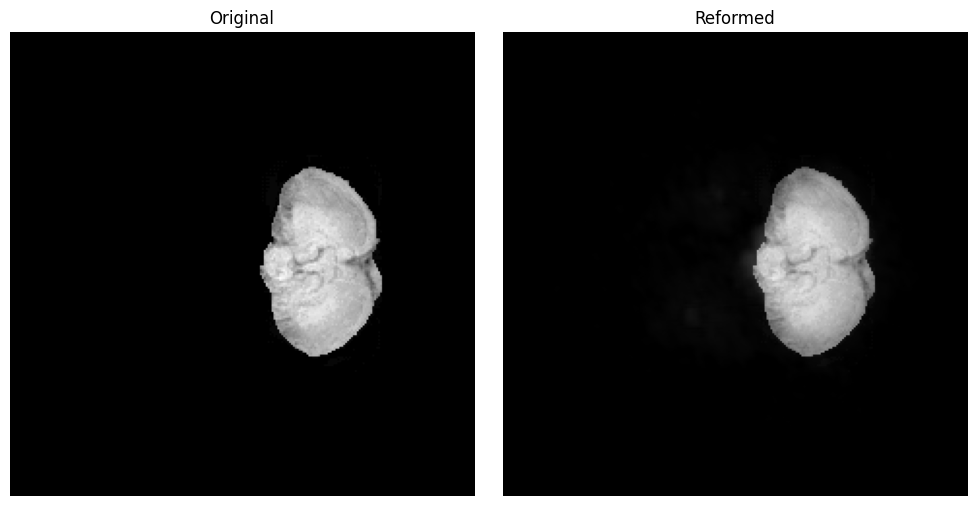

In [7]:
attack_name = "fgsm_0.1"  # Use your high HD95 case
attack_data = load_and_normalize_attack(attack_name)

# Get healed version through defense pipeline
healed_images = operator.reformer.heal(attack_data.data)

# Visualize first sample in batch
plot_original_and_reformed(attack_data.data[:10], healed_images[:10], slice_idx=65)